In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
votes = pd.DataFrame.from_csv('AnsVotes_TSeries.csv', index_col=None)
votes.head()

,QuestionId,AnsId,Age_vot,AnsWordCount,AcceptedAnsId,QScore,QVotes,Score,Votes,Upvotes,...,CumScore,ReScore,QReScore,Comments,AnsRank,ReScore_rank,Ans_count,Pbias,DRank,EPbias
0,1,56,0,201,56,0,0,2,2,2,...,0,0,0,0,1,1,1,1,0,1
1,2,10,0,145,10,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1
2,2,10,0,145,10,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1
3,3,9,0,25,109,0,0,4,4,4,...,0,0,0,0,1,1,1,1,0,1
4,7,16,0,45,2977,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1


In [3]:
users = pd.DataFrame.from_csv('user_reputation_votes.csv', index_col=None)
users.head()

,AnsId,QContributed,AnsContributed,ScoreRcvQ,VotRcvQ,ScoreRcvAns,VotRcvAns,Age
0,1,1,0,1,1,0,0,0
1,55,0,1,0,0,1,1,0
2,55,0,1,0,0,2,2,0
3,55,0,1,0,0,3,3,0
4,55,0,1,0,0,4,4,0


In [4]:
#There can be posts/votes with deleted users, we avoid them here
m_votes = pd.merge(users, votes, how='inner', on=['AnsId'],suffixes=['_vot', '_user'])

get_head = lambda df: pd.DataFrame(dict(zip(df.iloc[0].index,[[e] for e in df.iloc[0].values])))
ff = lambda df: get_head(df.sort_values(by=["Age"],ascending=False))
votes_complete = m_votes[m_votes.Age_vot>=m_votes.Age].groupby(['AnsId','Age_vot']).apply(ff).reset_index(drop=True)
votes_complete.head()

,AcceptedAnsId,Age,Age_vot,AnsContributed,AnsId,AnsRank,AnsWordCount,Ans_count,Comments,CumScore,...,QuestionId,ReScore,ReScore_rank,Score,ScoreRcvAns,ScoreRcvQ,Upvotes,VotRcvAns,VotRcvQ,Votes
0,56,0,0,5,4,2,190,2,0,0,...,1,0.00,2,1,12,0,2,14,0,3
1,56,1436,1436,7,4,3,190,6,2,1,...,1,0.25,5,1,49,11,1,55,11,1
2,56,0,0,1,5,3,37,3,0,0,...,1,0.00,3,1,1,0,1,1,0,1
3,56,108,108,2,5,5,37,5,1,1,...,1,0.50,3,-1,-2,0,0,4,0,1
4,10,0,0,1,6,5,51,5,0,0,...,2,0.00,5,1,1,0,1,1,0,1


In [5]:
from functools import partial

votes_complete['Reputation'] = votes_complete['VotRcvQ'] + votes_complete['VotRcvAns']
qtls_age = votes_complete['Age_vot'].quantile([0,.25,.5,.75,1.0]).values
age_groups = dict(zip(zip(qtls_age,qtls_age[1:]),[e for e in range(len(zip(qtls_age,qtls_age[1:])))]))

qtls_rep = votes_complete['Reputation'].quantile([0,.25,.5,.75,1.0]).values
rep_groups = dict(zip(zip(qtls_rep,qtls_rep[1:]),[e for e in range(len(zip(qtls_rep,qtls_rep[1:])))]))

def get_group(intervals,pred):
    for l,u in intervals:
        if l<=pred and pred<=u:
            return intervals[(l,u)]
get_age_group = partial(get_group,age_groups)
get_rep_group = partial(get_group,rep_groups)

In [6]:
votes_complete['Age_group'] = votes_complete['Age_vot'].apply(get_age_group)
votes_complete['Rep_group'] = votes_complete['Reputation'].apply(get_rep_group)
votes_r = votes_complete

In [7]:
rev_age_groups = {age_groups[(d1,d2)]:"%d to %d days"%(d1,d2) for d1,d2 in age_groups}

### Mean vs Variance for votes (Suggests overdispersion, so we use Negative Binomial regresion) Outlier is votes on questions with one answer

In [5]:
ff1 = lambda df: pd.DataFrame(dict(zip(['mean','var','count'],[[e] for e in np.around([df['Votes'].mean(),df['Votes'].var(),df['Votes'].count()],decimals=3)])))
mean_var_v = votes.groupby(['Age_vot']).apply(ff1).reset_index(level=[0],drop=False)
mean_var_v.head()

,Age_vot,count,mean,var
0,0,3443,2.435,2.892
0,1,3313,1.983,1.862
0,2,1728,1.361,0.493
0,3,1201,1.231,0.323
0,4,773,1.186,0.299


In [14]:
mean_var_v['count'].value_counts().head(10)

1     163
4     140
2     127
3     125
5     101
6      97
7      77
8      69
9      53
10     42
Name: count, dtype: int64

[]

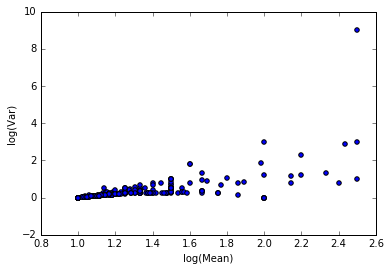

In [15]:
data = mean_var_v[(mean_var_v['count']>1)&(mean_var_v['mean']<=2.5)]
plt.scatter(x = data['mean'], y = data['var'])

#plt.legend(loc='lower right')
plt.xlabel('log(Mean)')
plt.ylabel('log(Var)')
plt.plot()

### The outlier

In [10]:
mean_var_v[np.log(mean_var_v['var'])>0.5]

,Ans_count,AnsRank,level_2,count,mean,var
0,1,1,0,4819,1.911,2.063


# Plots by Groups

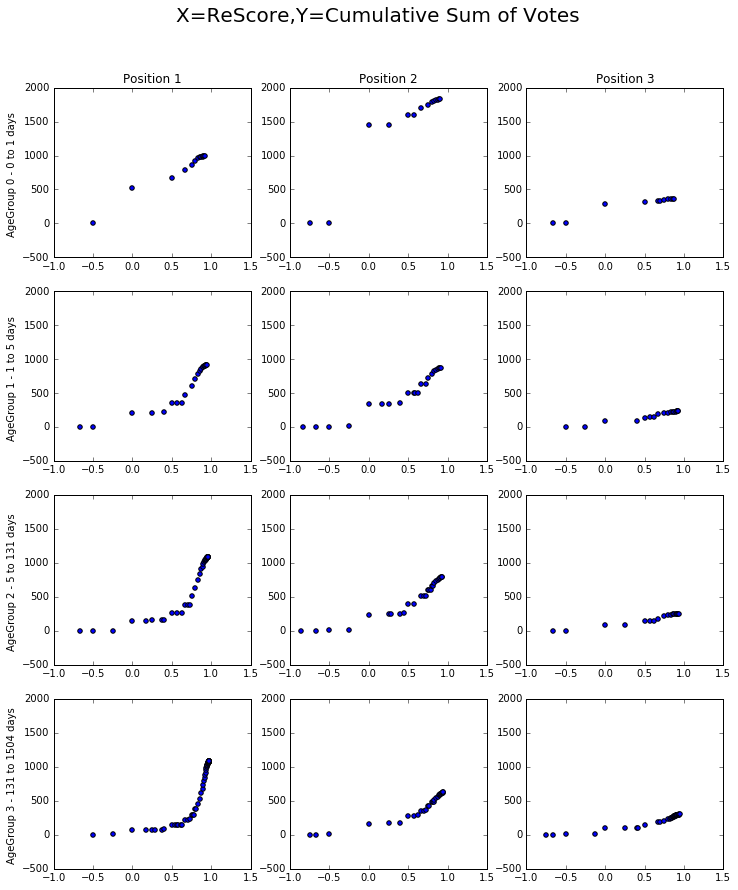

In [33]:
plt.figure(figsize=(12,14))
axref=0
nb_age_groups = 4
nb_ans = 3
groups = votes_complete[(votes_complete['Ans_count']>1)&(votes_complete['Ans_count']<=nb_ans)&(votes_complete['Age_group']<=nb_age_groups-1)]
groups = groups.sort_values(by=['Age_group']).groupby(['AnsRank','Age_group'])
for key,group in groups:
    position = group['AnsRank'].iloc[0]
    age_group = group['Age_group'].iloc[0]
    if position==1 and age_group==0:
        axref = plt.subplot(nb_age_groups, nb_ans,nb_ans*age_group + position)
    plt.subplot(nb_age_groups, nb_ans, nb_ans*age_group + position,sharex=axref,sharey=axref)
    cumvotes = group.groupby(['ReScore']).sum()['Votes'].cumsum()
    plt.scatter(x = cumvotes.index.values,y=cumvotes.values)
    if age_group==0:
        plt.title('Position %d'%(position))
    if position==1:    
        plt.ylabel('AgeGroup %d - %s '%(age_group,rev_age_groups[age_group]))
        
plt.suptitle('X=ReScore,Y=Cumulative Sum of Votes',fontsize=20)
plt.show()

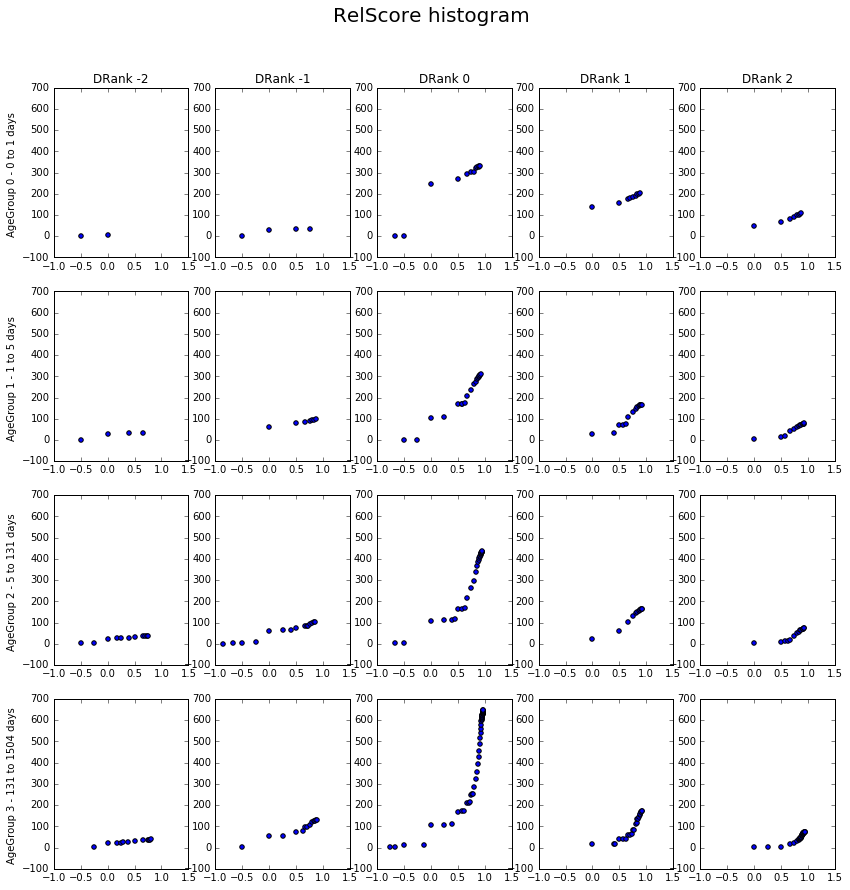

In [17]:
plt.figure(figsize=(14,14))
axref=0
nb_age_groups = 4
nb_ans = 3
nb_dranks = 2*(nb_ans-1)+1
groups = votes_complete[(votes_complete['Ans_count']==nb_ans)&(votes_complete['Age_group']<=nb_age_groups-1)]
groups = groups.sort_values(by=['Age_group']).groupby(['DRank','Age_group'])

for key,group in groups:
    drank = group['DRank'].iloc[0]
    age_group = group['Age_group'].iloc[0]
    position = nb_ans + drank
    if position==1 and age_group==0:
        axref = plt.subplot(nb_age_groups, nb_dranks,nb_dranks*age_group + position)
    plt.subplot(nb_age_groups, nb_dranks, nb_dranks*age_group + position,sharex=axref,sharey=axref)
    cumvotes = group.groupby(['ReScore']).sum()['Votes'].cumsum()
    plt.scatter(x = cumvotes.index.values,y=cumvotes.values)
    if age_group==0:
        plt.title('DRank %d'%(drank))
    if position==1:    
        plt.ylabel('AgeGroup %d - %s '%(age_group,rev_age_groups[age_group]))
        
plt.suptitle('RelScore histogram',fontsize=20)
plt.show()

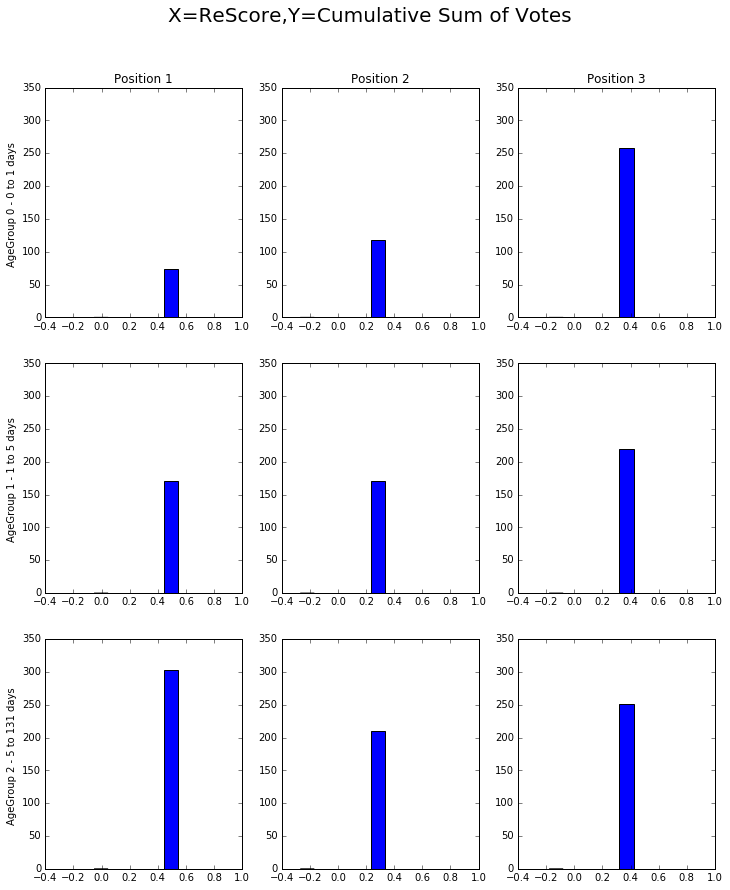

In [11]:
plt.figure(figsize=(12,14))
axref=0
nb_age_groups = 3
nb_ans = 3
groups = votes_complete[(votes_complete['Ans_count']==nb_ans)&(votes_complete['Age_group']<=nb_age_groups-1)]
groups = groups.sort_values(by=['Age_group']).groupby(['AnsRank','Age_group'])
for key,group in groups:
    position = group['AnsRank'].iloc[0]
    age_group = group['Age_group'].iloc[0]
    if position==1 and age_group==0:
        axref = plt.subplot(nb_age_groups, nb_ans,nb_ans*age_group + position)
    plt.subplot(nb_age_groups, nb_ans, nb_ans*age_group + position,sharex=axref,sharey=axref)
    plt.hist(group['EPbias'].values)
    if age_group==0:
        plt.title('Position %d'%(position))
    if position==1:    
        plt.ylabel('AgeGroup %d - %s '%(age_group,rev_age_groups[age_group]))
        
plt.suptitle('X=ReScore,Y=Cumulative Sum of Votes',fontsize=20)
plt.show()

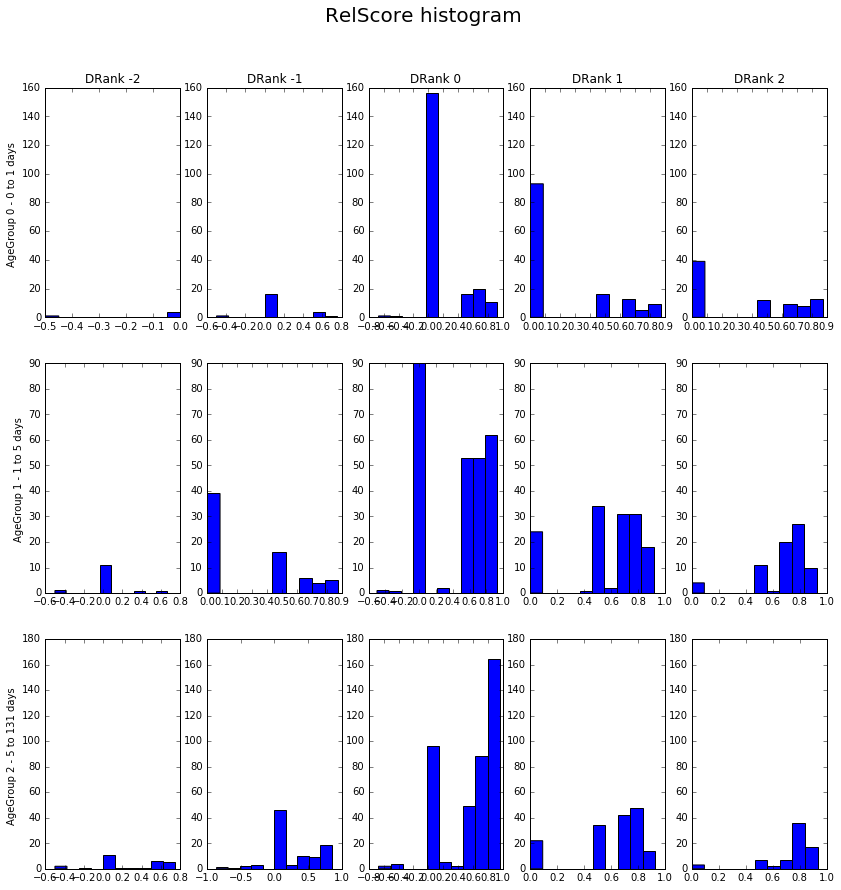

In [12]:
plt.figure(figsize=(14,14))
axref={}
nb_age_groups = 3
nb_ans = 3
nb_dranks = 2*(nb_ans-1)+1
groups = votes_complete[(votes_complete['Ans_count']==nb_ans)&(votes_complete['Age_group']<=nb_age_groups-1)]
groups = groups.sort_values(by=['Age_group']).groupby(['DRank','Age_group'])

for key,group in groups:
    drank = group['DRank'].iloc[0]
    age_group = group['Age_group'].iloc[0]
    position = nb_ans + drank
    if position==1:
        axref[age_group] = plt.subplot(nb_age_groups, nb_dranks,nb_dranks*age_group + position)
    plt.subplot(nb_age_groups, nb_dranks, nb_dranks*age_group + position,sharey=axref[age_group])
    plt.hist(group['ReScore'].values)
    if age_group==0:
        plt.title('DRank %d'%(drank))
    if position==1:    
        plt.ylabel('AgeGroup %d - %s '%(age_group,rev_age_groups[age_group]))
        
plt.suptitle('RelScore histogram',fontsize=20)
plt.show()

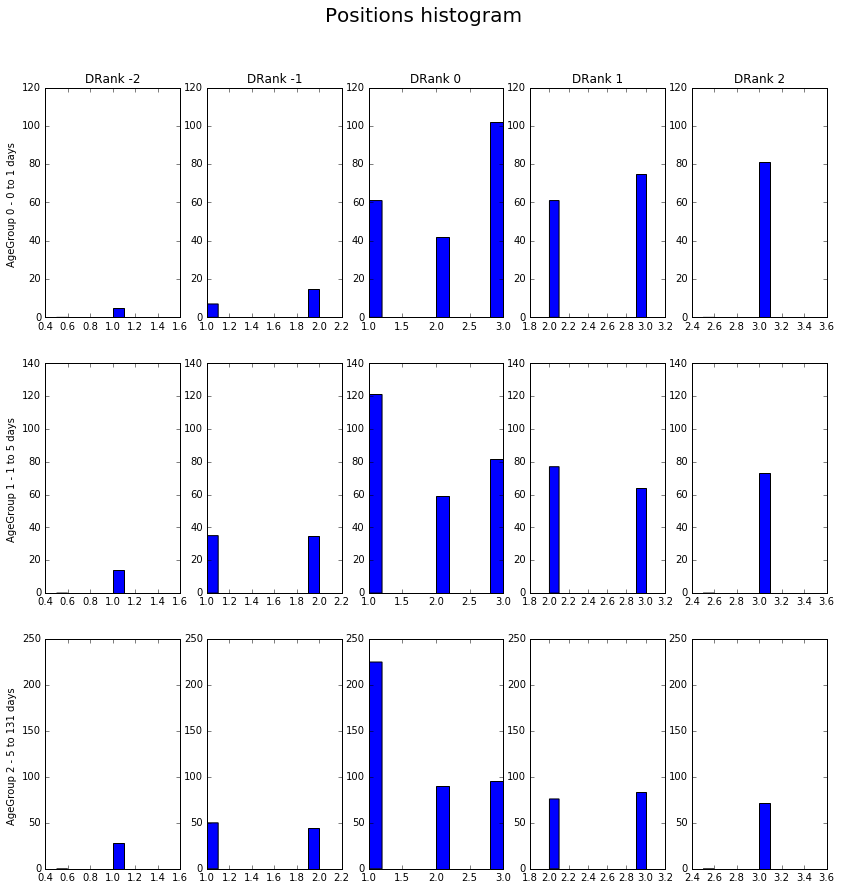

In [13]:
plt.figure(figsize=(14,14))
axref={}
nb_age_groups = 3
nb_ans = 3
nb_dranks = 2*(nb_ans-1)+1
groups = votes_complete[(votes_complete['Ans_count']==nb_ans)&(votes_complete['Age_group']<=nb_age_groups-1)]
groups = groups.sort_values(by=['Age_group']).groupby(['DRank','Age_group'])

for key,group in groups:
    drank = group['DRank'].iloc[0]
    age_group = group['Age_group'].iloc[0]
    position = nb_ans + drank
    if position==1:
        axref[age_group] = plt.subplot(nb_age_groups, nb_dranks,nb_dranks*age_group + position)
    plt.subplot(nb_age_groups, nb_dranks, nb_dranks*age_group + position,sharey=axref[age_group])
    plt.hist(group['AnsRank'].values)
    if age_group==0:
        plt.title('DRank %d'%(drank))
    if position==1:    
        plt.ylabel('AgeGroup %d - %s '%(age_group,rev_age_groups[age_group]))
        
plt.suptitle('Positions histogram',fontsize=20)
plt.show()

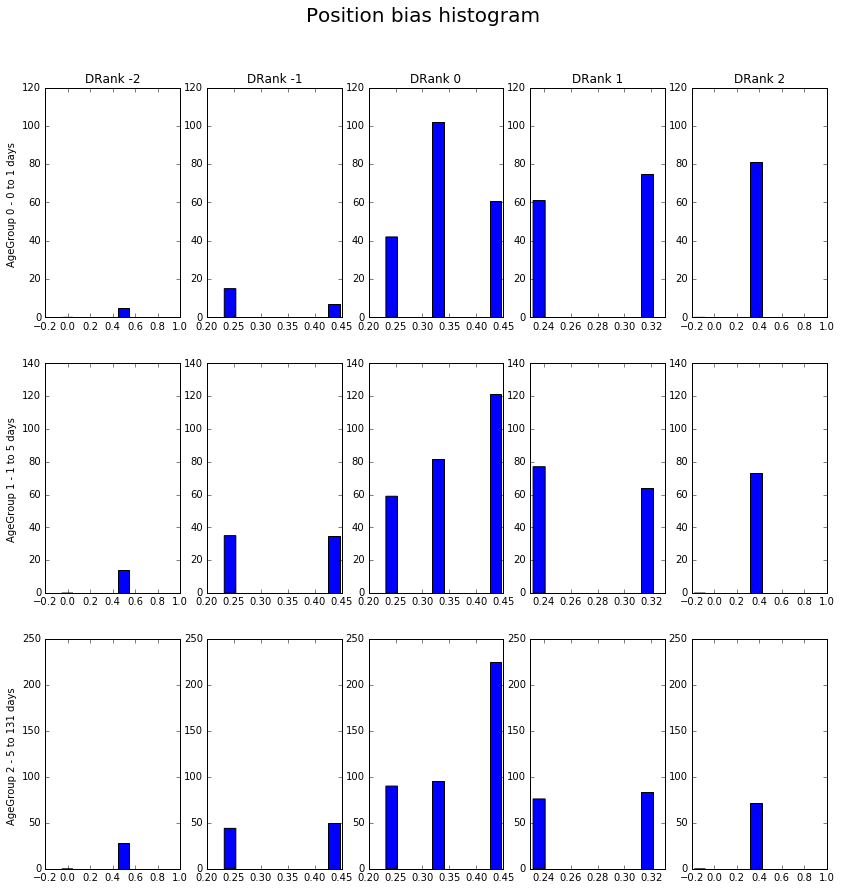

In [14]:
plt.figure(figsize=(14,14))
axref={}
nb_age_groups = 3
nb_ans = 3
nb_dranks = 2*(nb_ans-1)+1
groups = votes_complete[(votes_complete['Ans_count']==nb_ans)&(votes_complete['Age_group']<=nb_age_groups-1)]
groups = groups.sort_values(by=['Age_group']).groupby(['DRank','Age_group'])

for key,group in groups:
    drank = group['DRank'].iloc[0]
    age_group = group['Age_group'].iloc[0]
    position = nb_ans + drank
    if position==1:
        axref[age_group] = plt.subplot(nb_age_groups, nb_dranks,nb_dranks*age_group + position)
    plt.subplot(nb_age_groups, nb_dranks, nb_dranks*age_group + position,sharey=axref[age_group])
    plt.hist(group['EPbias'].values)
    if age_group==0:
        plt.title('DRank %d'%(drank))
    if position==1:    
        plt.ylabel('AgeGroup %d - %s '%(age_group,rev_age_groups[age_group]))
        
plt.suptitle('Position bias histogram',fontsize=20)
plt.show()

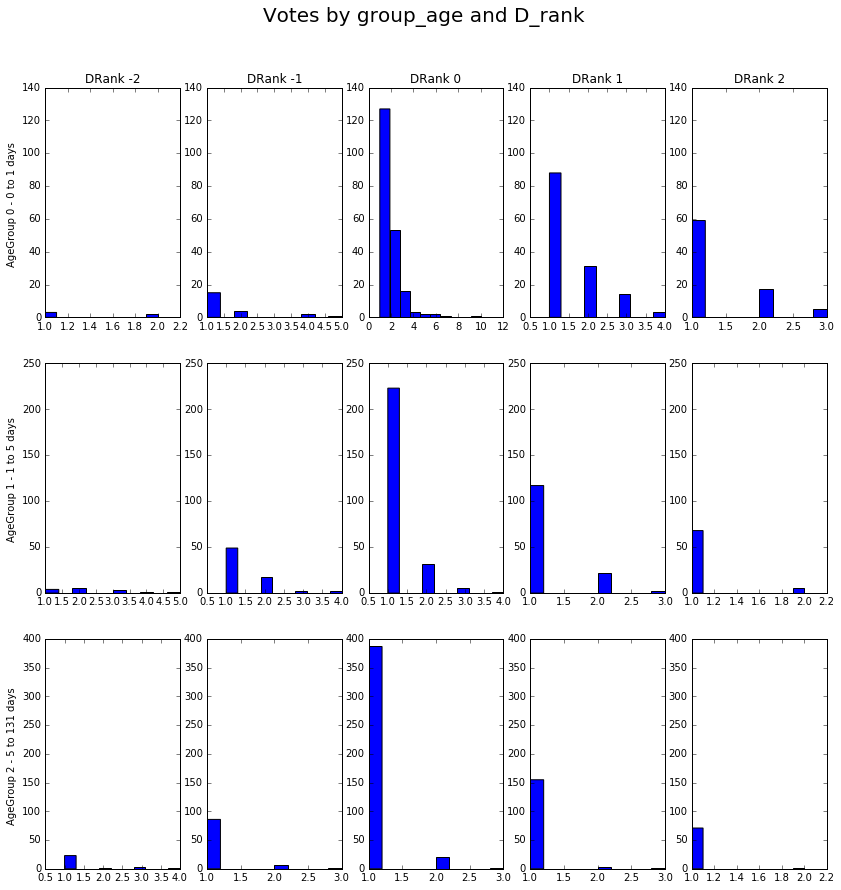

In [15]:
plt.figure(figsize=(14,14))
axref={}
nb_age_groups = 3
nb_ans = 3
nb_dranks = 2*(nb_ans-1)+1
groups = votes_complete[(votes_complete['Ans_count']==nb_ans)&(votes_complete['Age_group']<=nb_age_groups-1)]
groups = groups.sort_values(by=['Age_group']).groupby(['DRank','Age_group'])

for key,group in groups:
    drank = group['DRank'].iloc[0]
    age_group = group['Age_group'].iloc[0]
    position = nb_ans + drank
    if position==1:
        axref[age_group] = plt.subplot(nb_age_groups, nb_dranks,nb_dranks*age_group + position)
    plt.subplot(nb_age_groups, nb_dranks, nb_dranks*age_group + position,sharey=axref[age_group])
    plt.hist(group['Votes'].values)
    if age_group==0:
        plt.title('DRank %d'%(drank))
    if position==1:    
        plt.ylabel('AgeGroup %d - %s '%(age_group,rev_age_groups[age_group]))
        
plt.suptitle('Votes by group_age and D_rank',fontsize=20)
plt.show()